In [1]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from utils.mylib import *
from d2l import torch as d2l

In [2]:
init_Seed()

GPU ready!


In [3]:
class MF(nn.Module):
    def __init__(self, n_users=6050, m_items=4050, n_factors=50):
        super(MF, self).__init__()

        self.U = torch.nn.Parameter(torch.rand(n_users, n_factors, requires_grad=True))

        self.P = torch.rand(m_items, n_factors, requires_grad=False, device=device)
        self.Q = torch.nn.Parameter(torch.rand(n_factors, n_factors, requires_grad=True))
        
        # self.net = nn.Sequential(nn.Linear(n_factors, 500 * n_factors), nn.ReLU(), nn.Linear(500 * n_factors, n_factors))


        # self.init_net()

        self.U.data.uniform_(-0.05, 0.05)
        self.P.data.uniform_(-0.05, 0.05)
        self.Q.data.normal_(0, 0.1)
        
        self.criterion = nn.MSELoss(reduction='mean')
    
    def forward(self, user, item):
        return torch.einsum('ij, ij -> i', [self.U[user], self.P[item] @ self.Q])
        # return torch.einsum('ij, ij -> i', [self.U[user], self.net(self.P[item])])

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        return self.criterion(pred, target)
    
    # def init_net(self):
    #     def init_weights(m):
    #         if type(m) == nn.Linear:
    #             nn.init.normal_(m.weight, std=0.01)
    #     self.net.apply(init_weights)


In [4]:
def train(tr_set, dv_set, model, config):
    n_epochs = config['n_epochs']  # Maximum number of epochs
    batch_size = config['batch_size']

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.95)


    min_mse = 1000.
    loss_record = {'train': [], 'dev': []} 
    early_stop_cnt = 0
    epoch = 0

    while epoch < n_epochs:
        model.train()
        for X, y in tr_set:
            optimizer.zero_grad()    
            X, y = X.to(device), y.to(device)
            y_hat = model(X[:, 0], X[:, 1])

            mse_loss = model.cal_loss(y_hat, y)
            mse_loss.backward()
            
            optimizer.step()

            # loss_record['train'].append(mse_loss.detach().cpu().item())
            loss_record['train'].append(mse_loss.detach().cpu().item())

            # print("train_loss: {:.4f}".format(mse_loss.detach().cpu().item()))
            print("train_loss: {:.4f}".format(np.sqrt(mse_loss.detach().cpu().item())))

        scheduler.step()
        
        epoch += 1

        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            min_mse = dev_mse
            early_stop_cnt = 0
            print("Saving model (epoch = {:4d}  loss = {:.4f} )".format(epoch, np.sqrt(dev_mse)))
            torch.save(model.state_dict(), config['save_path'])
        else:
            early_stop_cnt += 1
        
        loss_record['dev'].append(dev_mse)

        if early_stop_cnt > config['early_stop']:
            break

    print("Finish training after {} epochs".format(epoch))
    return min_mse, loss_record

In [5]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/           

config = {
    'n_epochs': 500,              # maximum number of epochs
    'batch_size': 50000,               # mini-batch size for dataloader
    'optimizer': 'Adam',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.005,                # learning rate
        # 'weight_decay': 0.001
        # 'momentum': 0.9              # momentum for SGD
    },
    'early_stop': 5,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth',  # your model will be saved here
    'D': 50
}

# **Load data and model**

In [6]:
ML1M_train = '../data/ML1M/ML1M_copy1_train.txt'
ML1M_test = '../data/ML1M/ML1M_copy1_test.txt'

tr_set = prep_dataloader(ML1M_train, 'train', config['batch_size'])
dv_set = prep_dataloader(ML1M_test, 'dev', config['batch_size'])
# tt_set = prep_dataloader("data/ML100K/ML100K_copy1_test.txt", 'test', config['batch_size'], target_only=target_only)

Max user: 6040
Max item: 3952
Finished reading the train set of MoviesLen Dataset (600126 samples found, each dim = 2)
Max user: 6040
Max item: 3952
Finished reading the dev set of MoviesLen Dataset (200041 samples found, each dim = 2)


In [7]:
model = MF(n_factors=config['D']).to(device) 

# **Start Training!**

In [8]:
# %%time
# for _ in range(4):
#     model_loss, model_loss_record = train(tr_set, dv_set, model, config)
#     model.P = model.net(model.P).detach()
#     # model.net = nn.Sequential(nn.Linear(config['D'], config['D']), nn.ReLU(), nn.Linear(config['D'], config['D']))
#     # model = model.to(device)
#     model.init_net()
#     print("ending a era !!!")

model_loss, model_loss_record = train(tr_set, dv_set, model, config)

train_loss: 3.7512
train_loss: 3.7467
train_loss: 3.7565
train_loss: 3.7641
train_loss: 3.7613
train_loss: 3.7506
train_loss: 3.7519
train_loss: 3.7490
train_loss: 3.7508
train_loss: 3.7450
train_loss: 3.7472
train_loss: 3.7535
train_loss: 3.6597
Saving model (epoch =    1  loss = 3.7498 )
train_loss: 3.7496
train_loss: 3.7484
train_loss: 3.7521
train_loss: 3.7541
train_loss: 3.7524
train_loss: 3.7493
train_loss: 3.7453
train_loss: 3.7484
train_loss: 3.7517
train_loss: 3.7497
train_loss: 3.7461
train_loss: 3.7476
train_loss: 3.8413
Saving model (epoch =    2  loss = 3.7484 )
train_loss: 3.7401
train_loss: 3.7444
train_loss: 3.7446
train_loss: 3.7440
train_loss: 3.7466
train_loss: 3.7459
train_loss: 3.7494
train_loss: 3.7476
train_loss: 3.7398
train_loss: 3.7442
train_loss: 3.7460
train_loss: 3.7453
train_loss: 3.7211
Saving model (epoch =    3  loss = 3.7446 )
train_loss: 3.7357
train_loss: 3.7353
train_loss: 3.7419
train_loss: 3.7403
train_loss: 3.7403
train_loss: 3.7311
train_loss: 3

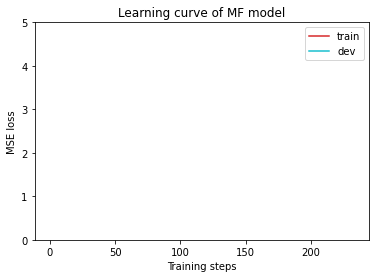

In [9]:
plot_learning_curve(model_loss_record, title='MF model')

In [10]:
np.sqrt(model_loss)

3.6836760959308625

In [11]:
np.sqrt(model_loss_record['dev'][-1])

3.6916185376571597

In [12]:
# del model
# model = MF().to(device)
# ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
# model.load_state_dict(ckpt)
# # plot_pred(dv_set, model, device)  # Show prediction on the validation set
# dev(dv_set, model, device)

# **Testing**
The predictions of your model on testing set will be stored at `pred.csv`.

In [13]:
# def save_pred(preds, file):
#     ''' Save predictions to specified file '''
#     print('Saving results to {}'.format(file))
#     with open(file, 'w') as fp:
#         writer = csv.writer(fp)
#         writer.writerow(['id', 'tested_positive'])
#         for i, p in enumerate(preds):
#             writer.writerow([i, p])

# preds = test(tt_set, model, device)  # predict COVID-19 cases with your model
# save_pred(preds, 'pred.csv')         # save prediction file to pred.csv

In [14]:
for X, y in dv_set:                         # iterate through the dataloader
    X, y = X.to(device), y.to(device)       # move data to device (cpu/cuda)
    with torch.no_grad():                   # disable gradient calculation
        pred = model(X[:, 0], X[:, 1])                     # forward pass (compute output)
        print(((pred -y) ** 2).mean())

# total_loss = total_loss / len(dv_set.dataset)   
    

tensor(13.4770, device='cuda:0')
tensor(13.6992, device='cuda:0')
tensor(13.5283, device='cuda:0')
tensor(13.8071, device='cuda:0')
tensor(14.3920, device='cuda:0')


In [15]:
# U = torch.nn.Parameter(torch.rand(2, 3, requires_grad=True))
# P = torch.nn.Parameter(torch.rand(2, 6, requires_grad=False))
# net = nn.Sequential(nn.Linear(6, 3), nn.ReLU())
# torch.einsum('ij, ij -> i', [U[[0, 1]], net(P[[0, 1]])])
# gg = torch.Tensor([0.3, 0.7])
# nn.Sigmoid()(gg)